In [3]:
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

data = pd.read_csv('../input/covid-dataset/20220304_Casos-e-obitos-ESP.csv', sep = ';')

# Análise exploratória

É possível visualizar que a base de dados contém apenas diagnósticos confirmados. Além disso há gêneros como 'INDEFINIDO', 'IGNORADO' e não declarados.

In [4]:
display(data.head())
display(data['Diagnostico Covid19'].unique())
display(data['Genero'].unique())

,Genero,Municipio,Asma,Diabetes,Cardiopatia,Doenca Hematologica,Doenca Hepatica,Doenca Neurologica,Doenca Renal,Imunodepressao,Obesidade,Pneumopatia,Puérpera,Síndrome De Down,Outros Fatores De Risco,Diagnostico Covid19,Data Inicio Sintomas,Idade,Obito
0,MASCULINO,POTIM,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,CONFIRMADO,21/03/2021,44.0,0
1,FEMININO,POTIM,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,CONFIRMADO,22/03/2021,66.0,0
2,MASCULINO,POTIM,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,CONFIRMADO,22/03/2021,0.0,0
3,MASCULINO,POTIM,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,CONFIRMADO,22/03/2021,22.0,0
4,FEMININO,POTIM,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,IGNORADO,CONFIRMADO,22/03/2021,25.0,0


array(['CONFIRMADO'], dtype=object)

array(['MASCULINO', 'FEMININO', 'INDEFINIDO', 'IGNORADO'], dtype=object)

# Incidência em homens e mulheres:

incidência em homens: 46.46944346501433%
incidencia em mulheres: 53.46055288219031%


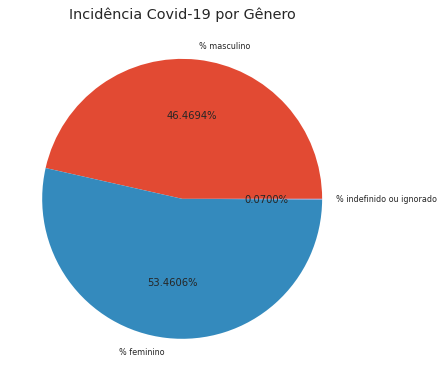

In [19]:
masc = data[(data['Genero'] == 'MASCULINO')].shape[0]
fem = data[(data['Genero'] == 'FEMININO')].shape[0]
total_confirm = data.shape[0]
ni = data[(data['Genero'] != 'MASCULINO') & (data['Genero'] != 'FEMININO')].shape[0]

plt.style.use('ggplot')
plt.figure(figsize=(12,6))
# Incidência em relação ao total de infectados, incluindo os de Genero 'INDEFINIDO', 'IGNORADO' e não declarado
print(f'incidência em homens: {(masc/total_confirm)*100.0}%\nincidencia em mulheres: {(fem/total_confirm)*100.0}%')
plt.pie([masc/total_confirm, fem/total_confirm, ni/total_confirm], labels = ['% masculino', '% feminino', '% indefinido ou ignorado'], autopct = '%1.4f%%', normalize = False)
plt.title('Incidência Covid-19 por Gênero')
plt.show()

# Taxa de mortalidade para cada faixa de idade:

In [ ]:
print(data['Obito'].unique())
data.dtypes

In [146]:
taxas = []
for i in range(0, max(data[data['Idade'].notnull()]['Idade'].unique().astype(int)), 10):
    n_obitos = data[(data['Idade']>=i) & (data['Idade']<i+10) & (data['Obito'] == 1)].shape[0]
    if n_obitos != 0:
        taxas.append((n_obitos/ data[(data['Idade']>=i) & (data['Idade'] < i + 10)].shape[0])*100)
    else: taxas.append(0.0)

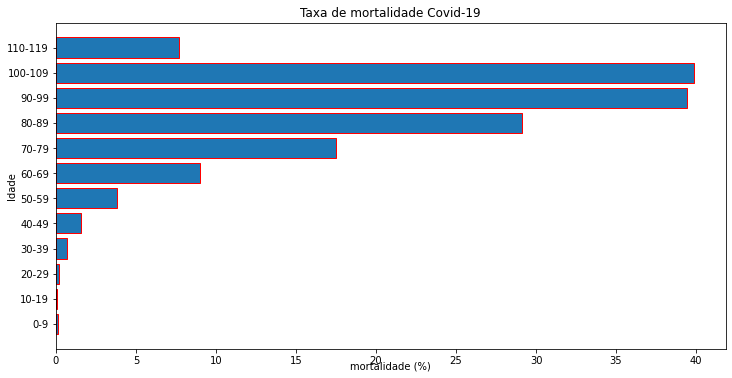

In [147]:
plt.figure(figsize=(12,6))
plt.title('Taxa de mortalidade Covid-19')

plt.ylabel('Idade', loc = 'center', labelpad = -10)
plt.xlabel('mortalidade (%)', loc = 'center', labelpad = -5)
plt.barh(range(0,len(taxas)), taxas, tick_label = [f'{i}-{i+9}' for i in range(0, len(taxas)*10, 10)], edgecolor = 'r')
plt.show()

# Doença pré-existente mais provável de ser encontrada em um contaminado:

In [20]:
doenças_d = {f'{doença}': data[data[f'{doença}'] == 'SIM'].shape[0] for doença in data.columns[2:-5]}
display(doenças_d)
display(f'Doença mais provável: {max(doenças_d, key = doenças_d.get)}')

{'Asma': 14309,
 'Diabetes': 260340,
 'Cardiopatia': 393121,
 'Doenca Hematologica': 3741,
 'Doenca Hepatica': 4070,
 'Doenca Neurologica': 19221,
 'Doenca Renal': 26993,
 'Imunodepressao': 31293,
 'Obesidade': 45781,
 'Pneumopatia': 16681,
 'Puérpera': 1473,
 'Síndrome De Down': 1367}

'Doença mais provável: Cardiopatia'

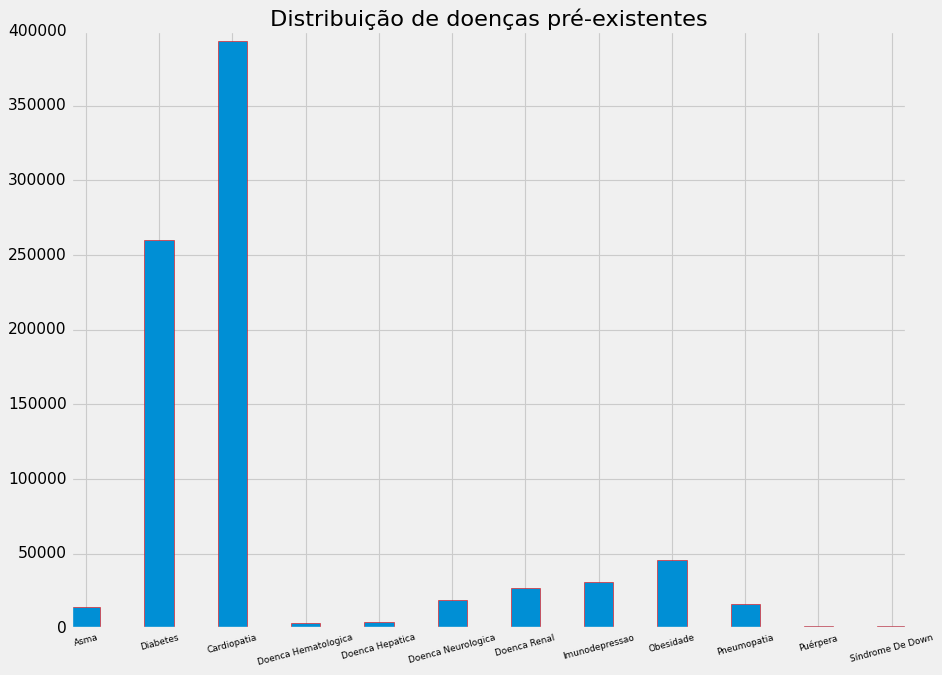

In [25]:
plt.style.use('fivethirtyeight')
plt.figure(figsize=(12,9))
plt.title('Distribuição de doenças pré-existentes')
plt.xticks(range(0,len(doenças_d)*2,2), data.columns[2:-5], fontsize = 8, rotation = (15))

plt.bar(range(0,len(data.columns[2:-5])*2,2), doenças_d.values(), edgecolor = 'r')
plt.show()

# Modelo preditivo para Obito por Covid-19:

One-hot-encoding da feature 'Genero':

In [6]:

data['Genero'] = data['Genero'].fillna(value = data['Genero'].mode().loc[0])
data['Genero'].replace({'IGNORADO': data['Genero'].mode().loc[0], 'INDEFINIDO': data['Genero'].mode().loc[0]}
                      , inplace = True)

one_hot = pd.get_dummies(data['Genero'])
data = data.drop('Genero', axis = 1)
data = data.join(one_hot)


In [7]:
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns

Como os samples em que a feature 'Idade' é nula apresentam apenas a classe 'Obito' como 0, não haveria perda de generalidade no modelo ao removê-los do dataset, uma vez que a classe majoritária para 'Obito' é 0.

In [28]:
data[(data['Idade'].isnull() == True) & (data['Obito'] == 1)].shape[0]

0

In [8]:
data= data[data['Idade'].isnull() == False]

As Doenças descritas como 'IGNORADO' serão atribuídas o valor referente a classe 0. Outras abordagens poderiam ser feitas para imputar categorias e que talvez melhorariam a precisão do modelo, uma delas seria preencher cada sample ignorado com valores mais prováveis usando K-vizinhos. Ou também criar novas categorias para indicar quando a presença de uma doença foi ignorada. 

In [9]:
d_map = {'NÃO': 0, 'SIM': 1, 'IGNORADO': 0}
for col in data.columns[1:-6]: data[col] = data[col].map(d_map)

# Ao visualizar a correlação entre as variáveis categóricas pelo coeficiente V de Cramer, é possível concluir que o 'Genero' tem baixa relação com a classe 'Obito' e as outras features, portanto pode ser excluído do modelo:

Para a feature 'Idade' contínua foi usado por padrão o coeficiente R de Pearson:

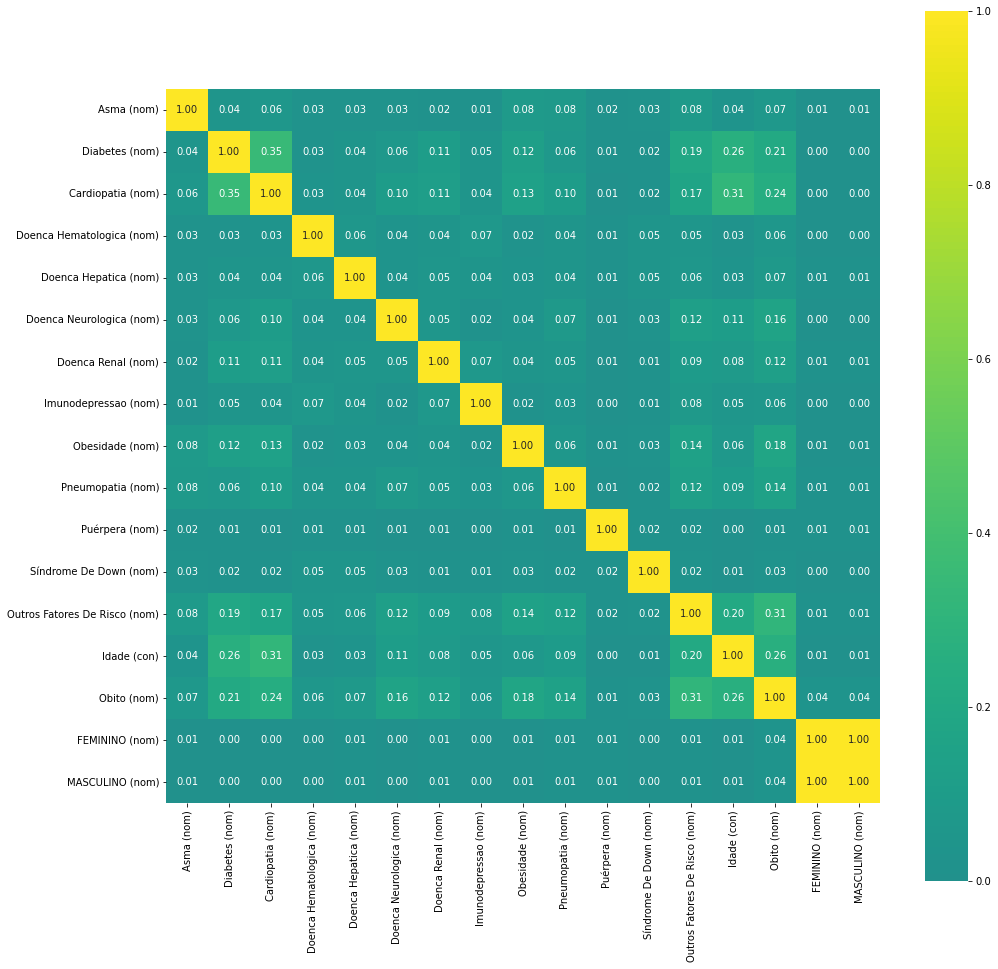

{'corr':                                Asma (nom)  Diabetes (nom)  Cardiopatia (nom)  \
 Asma (nom)                       1.000000        0.042374           0.056222   
 Diabetes (nom)                   0.042374        1.000000           0.346919   
 Cardiopatia (nom)                0.056222        0.346919           1.000000   
 Doenca Hematologica (nom)        0.028852        0.028440           0.034573   
 Doenca Hepatica (nom)            0.028194        0.041968           0.039281   
 Doenca Neurologica (nom)         0.026386        0.062577           0.098638   
 Doenca Renal (nom)               0.019956        0.105541           0.111926   
 Imunodepressao (nom)             0.011601        0.045395           0.040946   
 Obesidade (nom)                  0.082144        0.117359           0.134098   
 Pneumopatia (nom)                0.077491        0.064911           0.096993   
 Puérpera (nom)                   0.017723        0.008957           0.006242   
 Síndrome De Down (n

In [44]:
from dython.nominal import associations
cols = [col for col in data.columns[1:-6]]
nom_ = cols+['Obito', 'FEMININO', 'MASCULINO']
cols.extend(['Idade', 'Obito', 'FEMININO', 'MASCULINO'])
associations(data[cols],nom_nom_assoc = 'cramer', nan_strategy='replace',nan_replace_value = 0, nominal_columns= nom_, mark_columns = True, cmap = 'viridis',
             figsize=(16,16))

# Para o coeficiente U de Theil, é possível visualizar uma relação assimétrica entre as features e a classe alvo, mas que ainda é coerente com a anterior:

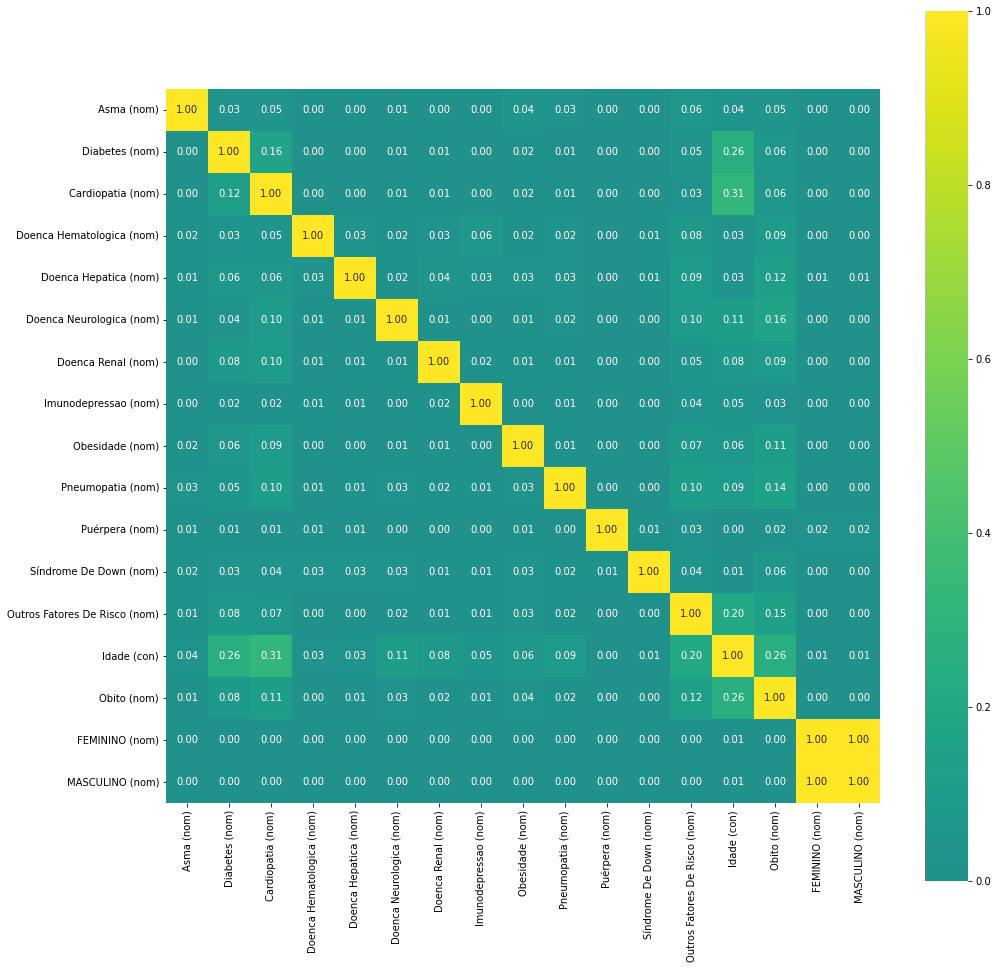

{'corr':                                Asma (nom)  Diabetes (nom)  Cardiopatia (nom)  \
 Asma (nom)                       1.000000    2.600297e-02           0.046278   
 Diabetes (nom)                   0.002502    1.000000e+00           0.160330   
 Cardiopatia (nom)                0.003305    1.190165e-01           1.000000   
 Doenca Hematologica (nom)        0.015280    3.398931e-02           0.052710   
 Doenca Hepatica (nom)            0.014093    6.023288e-02           0.061466   
 Doenca Neurologica (nom)         0.005163    4.057229e-02           0.097165   
 Doenca Renal (nom)               0.002748    7.624226e-02           0.095658   
 Imunodepressao (nom)             0.001049    1.717921e-02           0.015543   
 Obesidade (nom)                  0.016907    6.472380e-02           0.091106   
 Pneumopatia (nom)                0.026340    4.730971e-02           0.104074   
 Puérpera (nom)                   0.013367    9.702448e-03           0.005543   
 Síndrome De Down (n

In [10]:
from dython.nominal import associations
cols = [col for col in data.columns[1:-6]]
nom_ = cols+['Obito', 'FEMININO', 'MASCULINO']
cols.extend(['Idade', 'Obito', 'FEMININO', 'MASCULINO'])
associations(data[cols],nom_nom_assoc = 'theil', nan_strategy='replace',nan_replace_value = 0, mark_columns = True, nominal_columns= nom_, cmap = 'viridis',
             figsize=(16,16))

mais detalhes sobre as métricas usadas: https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9

In [42]:
{doenca: data[(data[doenca] == 1) & (data['Obito'] == 1)].shape[0]/data[(data[doenca] == 1)].shape[0] for doenca in data.columns[1:-6]}

{'Asma': 0.2516597945349081,
 'Diabetes': 0.19296703635599657,
 'Cardiopatia': 0.17742412649834227,
 'Doenca Hematologica': 0.413258487035552,
 'Doenca Hepatica': 0.48574938574938575,
 'Doenca Neurologica': 0.5029394932625774,
 'Doenca Renal': 0.33620721691627337,
 'Imunodepressao': 0.17015193858212072,
 'Obesidade': 0.35862038837072147,
 'Pneumopatia': 0.4745518853785744,
 'Puérpera': 0.17311608961303462,
 'Síndrome De Down': 0.35698610095098754,
 'Outros Fatores De Risco': 0.3682839830457883}

Visualizando outliers para as Idades maiores que 100 anos:

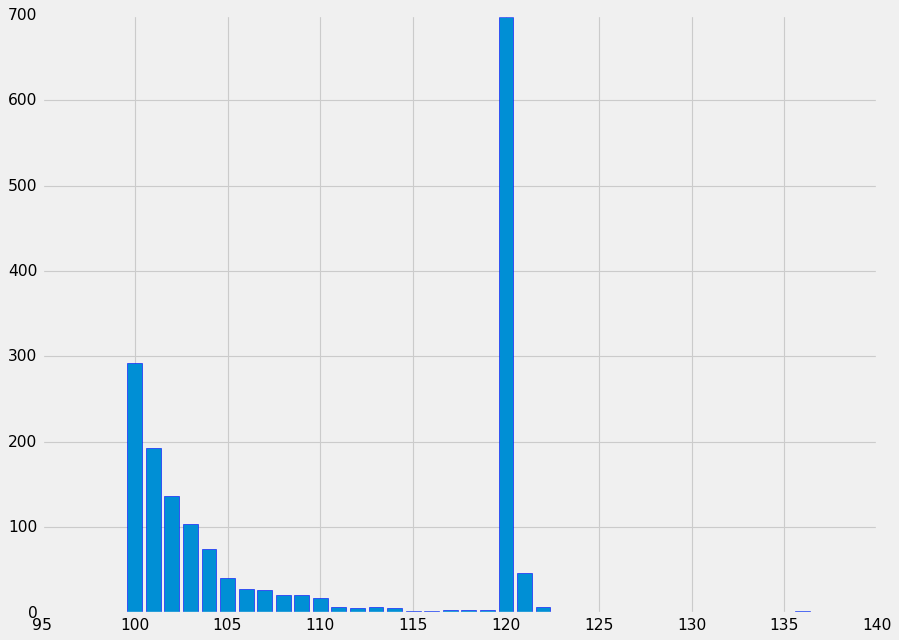

In [39]:
plt.figure(figsize=(12,9))
plt.bar(np.sort(data[data['Idade']>=100]['Idade'].unique()),data[data['Idade']>=100]['Idade'].value_counts().sort_index(), edgecolor = 'b')
plt.show()

Há uma distribuição atípica para as Idades de 120 e 121 anos. Idade acima dessa faixa serão removidas do dataset

In [7]:
data = data[data['Idade']<120]


Selecionando features que tem mais correlação com a classe alvo:

In [8]:
labels = ['Cardiopatia', 'Outros Fatores De Risco', 'Asma','Pneumopatia','Obesidade','Doenca Neurologica','Doenca Hepatica',
          'Diabetes', 'Doenca Hematologica', 'Doenca Renal', 'Síndrome De Down','Idade']
x = data[labels].values
y = data['Obito'].values

Relação de proporção entre as classes:

In [45]:
print('Relação minoritária:majoritária:', np.bincount(y)[1]/np.bincount(y)[0])

Relação minoritária:majoritária: 0.034338265402938266


Dividir os samples de forma que ambas as classes alvo tenham a mesma proporção em cada split:

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)

In [47]:
print(np.unique(y_test, return_counts = True), np.unique(y_train, return_counts = True))

(array([0, 1]), array([961219,  33007])) (array([0, 1]), array([3844877,  132026]))


Aplicar técnicas para lidar com esse desbalanceamento, como o oversampling: aumentando a classe minoritária tanto quanto se queira, para isso duplicando aleatoriamente os samples existentes ou produzindo novos samples com SMOTE:

In [10]:
import joblib
from joblib import parallel_backend

In [ ]:
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(0.5)
x_train, y_train = os.fit_resample(x_train,y_train)
print(np.unique(y_test, return_counts = True), np.unique(y_train, return_counts = True))

In [ ]:
from imblearn.over_sampling import SMOTENC
os = SMOTENC(sampling_strategy= 'auto', categorical_features = [i for i in range(0, x_train.shape[1] -1)], n_jobs = -1)
with joblib.parallel_backend('threading'):
    x_train,y_train = os.fit_resample(x_train,y_train)
print(np.unique(y_test, return_counts = True), np.unique(y_train, return_counts = True))

pré-processamento:

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
x_train[:, -1:] = scaler.fit_transform(x_train[:, -1].reshape(-1,1))
x_test[:, -1:] = scaler.transform(x_test[:, -1:].reshape(-1,1))


Para o treinamento do modelo foi escolhido o algoritmo RandomForest. Diversos outros modelos de classificação e também de regressão foram testados mas não apresentaram diferença considerável em métricas de precisão.

In [13]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report

In [14]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf= 1,
                             max_features='auto',
                             min_samples_split = 0.01,
                             bootstrap = True,
                             oob_score = True,
                             verbose = 2)


Backward feature selection:

In [65]:
bwd_fs = SequentialFeatureSelector(clf, n_features_to_select = 1.0,
                                  direction = 'backward',
                                  scoring = 'f1', cv = 5, n_jobs = -1)
with joblib.parallel_backend('threading'):
    fit_bwd = bwd_fs.fit(x_train, y_train)

In [66]:
fit_bwd.n_features_to_select_

12

In [ ]:
x_train = fit_fwd.transform(x_train)


GridSearchCV para hyperparameter tuning:

In [ ]:
w = np.linspace(0.05, 0.95, 20)
gs = GridSearchCV(estimator = RandomForestClassifier(), param_grid = {'n_estimators': [10], 'min_samples_leaf': [1],
                                                                              'max_features': ['auto'],
                                                                               'min_samples_split': [0.01],
                                                                              'bootstrap': [True],
                                                                              'oob_score': [False],
                                                                              'class_weight': [{1: x, 0: 1.0-x} for x in w]},
                   scoring = 'f1', n_jobs = -1, cv = StratifiedKFold(n_splits = 3)
                                                                                , verbose = 0)
with joblib.parallel_backend('threading'): 
    gs.fit(x,y)

In [ ]:
gs.best_params_

Treino do modelo:

In [15]:
clf = RandomForestClassifier(n_jobs=-1, n_estimators=100, min_samples_leaf= 1,
                             max_features='auto',
                             min_samples_split = 0.01,
                             bootstrap = True,
                             class_weight = {1: 0.7605263157894736, 0: 0.2394736842105264},
                             oob_score = True,
                             verbose = 0)
with joblib.parallel_backend('threading'):      
        clf.fit(x_train, y_train)

In [16]:
model_pred = clf.predict(x_test)
print("oob score:", clf.oob_score_)
print("Accuracy:", metrics.accuracy_score(y_true = y_test, y_pred = model_pred))
print("F1 Score:", metrics.f1_score(y_true =y_test, y_pred =model_pred))
print("Precision:", metrics.precision_score(y_true = y_test,y_pred =model_pred))
print("Recall:", metrics.recall_score(y_true = y_test,y_pred =model_pred))
print(classification_report(y_true = y_test,y_pred =model_pred))
pd.crosstab(pd.Series(model_pred, name = 'Predicted'), pd.Series(y_test, name = 'Actual'))

oob score: 0.9558108407471845
Accuracy: 0.9561890354909246
F1 Score: 0.4339294068721734
Precision: 0.37994128490475865
Recall: 0.5058017996182628
              precision    recall  f1-score   support

           0       0.98      0.97      0.98    961219
           1       0.38      0.51      0.43     33007

    accuracy                           0.96    994226
   macro avg       0.68      0.74      0.71    994226
weighted avg       0.96      0.96      0.96    994226



Actual,0,1
Predicted,,
0,933973,16312
1,27246,16695


Como é possível observar, as métricas de score indicam que o modelo é consistente, com baixíssimo número de FN's e FP's quando a classe 'Obito' prevista pelo modelo é 0. Quando é 1 não desempenha tão bem: com recall de 52% e precisão de 36%, com baixa sensibilidade. Vale ressaltar que essa limitação de performance está relacionada a baixa taxa de mortalidade em geral para as diferentes faixas de Idade. Em situações desse tipo, ao prever se determinada pessoa corre risco de morte ou não, o trade-off nas métricas preferível a se maximizar é o recall, uma vez que é menos nocivo prever erroneamente que determinada pessoa corre risco de morte a prever que ela não corre riscos.

# Distribuição de probabilidades para a classe 1:

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'test')

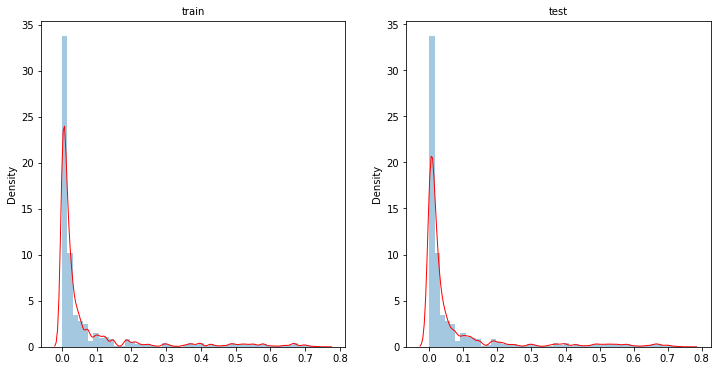

In [17]:
pred_probs_train = clf.predict_proba(x_train)[:,1]
pred_probs_test = clf.predict_proba(x_test)[:,1]

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(pred_probs_train, kde_kws = {'color': 'red', 'linewidth': 1})
plt.title("train", fontsize=10)

plt.subplot(1,2,2)
sns.distplot(pred_probs_test, kde_kws = {'color': 'red', 'linewidth': 1})
plt.title("test", fontsize=10)

# Visualizar a proporção de samples observada para a classe 'Obito' = 1 em função da probabilidade prevista para 20 agrupamentos de 0 a 1.0 utilizando a curva de confiabilidade:

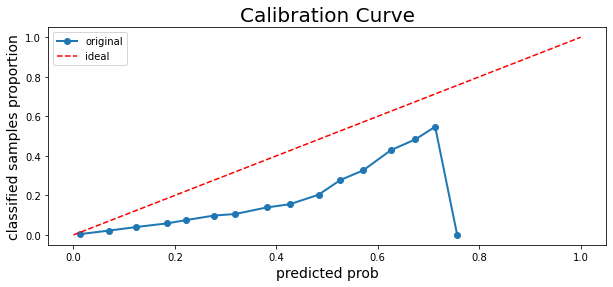

In [143]:
from sklearn.calibration import calibration_curve
prop_true_bin, prob_pred_bin = calibration_curve(y_test, pred_probs_test,n_bins = 20)

plt.figure(figsize=(10,4))
plt.plot(prob_pred_bin, prop_true_bin, linewidth=2, marker='o')
plt.title("Calibration Curve", fontsize=20)
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('classified samples proportion', fontsize=14)
    
plt.plot([0,1],[0,1],linestyle='--',color='red')
    
plt.legend(['original', 'ideal'], fontsize=10)

In [119]:
from sklearn.metrics import log_loss
print('Proporção de samples:',prop_true_bin)
print('Probabilidade prevista:',prob_pred_bin)
print('Log-loss:',log_loss(y_test, pred_probs_test))

Proporção de samples: [0.00405982 0.02169539 0.04005911 0.05849517 0.07463112 0.09804169
 0.10566777 0.13874496 0.15541543 0.20340587 0.27747916 0.326365
 0.42955326 0.48317609 0.54745098 0.        ]
Probabilidade prevista: [0.0129999  0.06965545 0.12407291 0.18519764 0.22117897 0.27737505
 0.31879821 0.38060342 0.42698785 0.48320104 0.52607064 0.57098305
 0.62632362 0.67407299 0.71302706 0.75648937]
Log-loss: 0.11468055194125257


In [130]:
np.unique(pred_probs_test>0.75, return_counts = True)

(array([False,  True]), array([994224,      2]))

A discrepância do último agrupamento pode ser explicada pelo baixo número de samples que foram classificados com uma probabilidade maior que 0.75 (apenas 2)

# Como foi visto acima, as probabilidades estimadas definitivamente não estão calibradas: o modelo está estimando probabilidades acima do esperado. Isso ocorre devido ao algoritmo de classificação, em que a probabilidade prevista está relacionada ao número de árvores que votaram para a classe 1, e não à probabilidade real observada na proporção de amostras de treino. Uma possível solução para esse problema seria construir um modelo de calibração que recebe como entrada as saídas do modelo de classificação e produz novas probabilidades mais assertivas, esse novo modelo pode ser um algoritmo de regressão logística, por exemplo.
mais informações sobre o funcionamento do algoritmo: https://scikit-learn.org/stable/modules/calibration.html 1.16.2 e 1.16.3 

Dividir os dados de teste anteriores para calibração e validação do modelo de calibração:

In [133]:
from sklearn.calibration import CalibratedClassifierCV
cccv = CalibratedClassifierCV(base_estimator= clf, method = 'sigmoid',cv = 'prefit', n_jobs=-1)
x_cal, x_val, y_cal, y_val = train_test_split(x_test, y_test, test_size = 0.2, stratify = y_test)
with joblib.parallel_backend('threading'):
    cccv.fit(x_cal, y_cal)
    

In [134]:
cb_prob = cccv.predict_proba(x_val)[:,1]

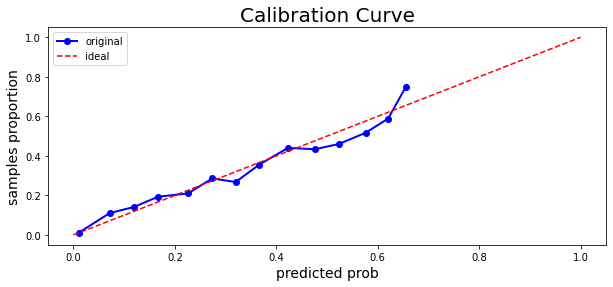

In [140]:
prop_cal_true_bin, cb_prob_bin = calibration_curve(y_val, cb_prob,n_bins = 20)
plt.figure(figsize=(10,4))
plt.plot(cb_prob_bin, prop_cal_true_bin, linewidth=2, marker='o', color = 'blue')
plt.title("Calibration Curve", fontsize=20)
plt.xlabel('predicted prob', fontsize=14)
plt.ylabel('samples proportion', fontsize=14)
   
plt.plot([0,1],[0,1],linestyle='--',color='red')
   
plt.legend(['original', 'ideal'], fontsize=10)

In [136]:
print('Proporção de samples:',prop_cal_true_bin)
print('Probabilidade prevista:',cb_prob_bin)
print('Log-loss:',log_loss(y_val, cb_prob))

Proporção de samples: [0.01038952 0.11014807 0.14148104 0.19335142 0.20969388 0.28578947
 0.2674581  0.35598227 0.44038929 0.43328748 0.45965139 0.51716501
 0.58865248 0.75      ]
Probabilidade prevista: [0.0101151  0.07116494 0.11939215 0.16703716 0.22567607 0.27379106
 0.31963757 0.36651413 0.42304216 0.47542843 0.52287985 0.57633356
 0.62046992 0.65542828]
Log-loss: 0.09657224425009707


# O modelo de calibração foi capaz de produzir probabilidades para a classe alvo mais próximas à proporção de samples que foram classificados com a classe 1.

Curva AUC ROC indicando as taxas de TP por FP e a área:

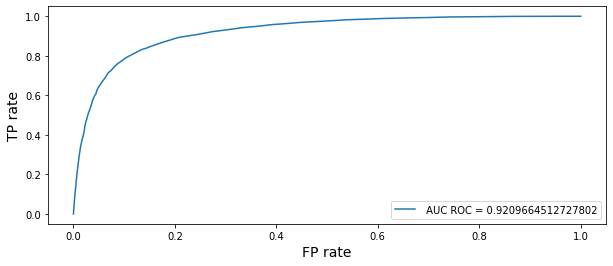

In [137]:
from sklearn.metrics import roc_auc_score, roc_curve

fpr, tpr, thresholds = roc_curve(y_val,  cb_prob)
auc = roc_auc_score(y_val, cb_prob)
plt.figure(figsize=(10,4))
plt.plot(fpr,tpr,label=f" AUC ROC = {auc}")
plt.xlabel('FP rate', fontsize=14)
plt.ylabel('TP rate', fontsize=14)
plt.legend(loc=4)
plt.show()

# Comparar a taxa de mortalidade por Idade com as probabilidades previstas:

In [160]:
probs_i = [np.mean(cccv.predict_proba(x_val[:])[:,1][scaler.inverse_transform(x_val[:, -1:]).reshape(-1,) == i]) for i in np.unique(scaler.inverse_transform(x_val[:, -1:]))]

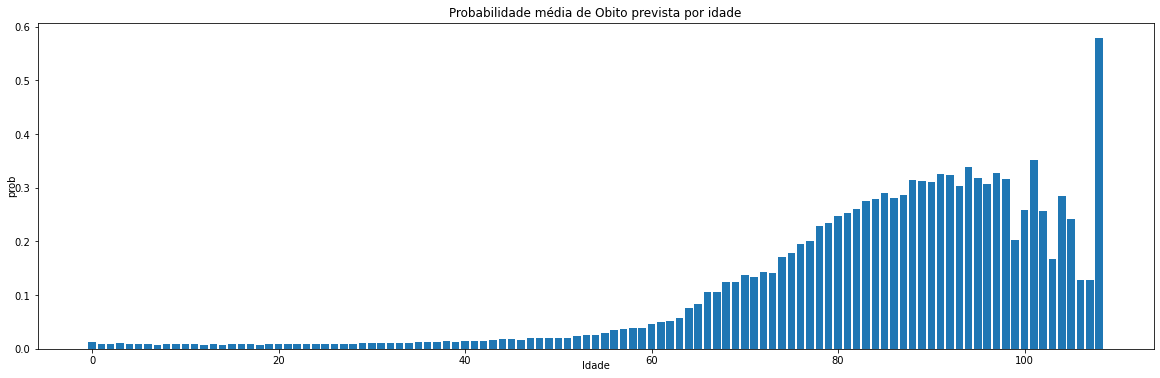

In [185]:
plt.figure(figsize=(20,6))
plt.title('Probabilidade média de Obito prevista por idade')

plt.ylabel('prob', loc = 'center', labelpad = -2.5)
plt.xlabel('Idade', loc = 'center', labelpad = -5)
plt.bar(x = [i for i in range(0, len(np.unique(scaler.inverse_transform(x_val[:, -1:]))))],
            height = probs_i)
plt.show()

In [182]:
import math
prob_bins = [np.mean(x) for x in np.array_split(probs_i, math.ceil(len(probs_i)/10))]
true_rate_bins = np.divide(taxas, 100)[:-1]

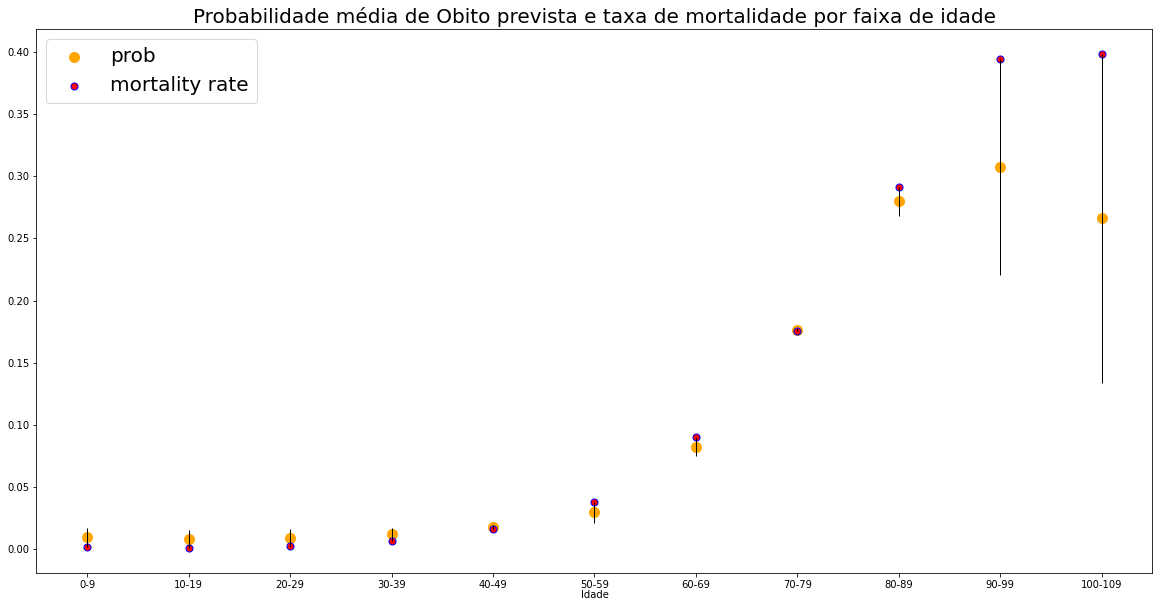

In [184]:
plt.figure(figsize=(20,10))
plt.title('Probabilidade média de Obito prevista e taxa de mortalidade real por faixa de idade', fontsize=20)

plt.xlabel('Idade', loc = 'center', labelpad = -5, fontsize=10.0)
plt.scatter(x = [i for i in range(0, len(prob_bins))],
            y = prob_bins, c = 'orange', linewidths = 5.0)
plt.scatter(x = [i for i in range(0, len(true_rate_bins))],
            y = true_rate_bins, c = 'red', s = 50, linewidths = 1,  marker = 'o', edgecolors = 'blue')

plt.errorbar(x = [i for i in range(0, len(prob_bins))], y = prob_bins, yerr=[y-x for x,y in zip(prob_bins,true_rate_bins)], fmt='none',
             ecolor='black', elinewidth=1, capsize=0, barsabove = False)

plt.xlabel('Idade', loc = 'center', labelpad = 0)

plt.xticks(range(0,len(true_rate_bins)), [f'{i}-{i+9}' for i in range(0, len(true_rate_bins)*10, 10)], fontsize = 10)

plt.legend(['prob', 'mortality rate'], fontsize=20)
plt.show()